In [2]:
# Phase-3: Model Development (Simple, Multiple, Logistic Regression)

import pandas as pd
import numpy as np
from pathlib import Path

# ML
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import (
    r2_score, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, precision_recall_curve
)

# Plotting (matplotlib only, no seaborn/colors)
import matplotlib.pyplot as plt

# Load model-ready data
path = Path("spambase_model_ready.csv")
df = pd.read_csv(path)

target_col = "is_spam"
y = df[target_col].astype(int).values
X = df.drop(columns=[target_col])
feature_names = X.columns.tolist()

print("Data shape:", df.shape)
print("Target positive rate (spam=1):", y.mean().round(4))

Data shape: (4210, 58)
Target positive rate (spam=1): 0.3988


In [4]:
# Stratified split to preserve class balance
X_train, X_test, y_train, y_test = train_test_split(
    X.values, y, test_size=0.30, random_state=42, stratify=y
)

print("Train size:", X_train.shape, " Test size:", X_test.shape)
print("Train spam rate:", y_train.mean().round(4), " Test spam rate:", y_test.mean().round(4))

Train size: (2947, 57)  Test size: (1263, 57)
Train spam rate: 0.3987  Test spam rate: 0.399


In [6]:
# Pick the single best predictor by absolute correlation with target (on TRAIN set only)
corrs = {}
for i, fname in enumerate(feature_names):
    corrs[fname] = np.corrcoef(X_train[:, i], y_train)[0,1]
best_feat = max(corrs, key=lambda k: abs(corrs[k]))
best_idx = feature_names.index(best_feat)

# Fit linear regression on that single predictor
lin_simple = LinearRegression()
lin_simple.fit(X_train[:, [best_idx]], y_train)

# Equation y = b0 + b1*x
b0 = float(lin_simple.intercept_)
b1 = float(lin_simple.coef_[0])

# R^2 on test set
y_pred_simple = lin_simple.predict(X_test[:, [best_idx]])
r2_simple = r2_score(y_test, y_pred_simple)

print("SIMPLE REGRESSION")
print(f"Best predictor: {best_feat}  (corr={corrs[best_feat]:.3f})")
print(f"Equation: is_spam = {b0:.4f} + ({b1:.4f})*{best_feat}")
print(f"R^2 (test): {r2_simple:.4f}")

# Quick interpretation text
direction = "increases" if b1 > 0 else "decreases"
print(f"Interpretation: Holding other factors aside, a 1 SD increase in {best_feat} {direction} the expected spam score by {abs(b1):.4f} (linear probability model).")


SIMPLE REGRESSION
Best predictor: word_freq_your  (corr=0.383)
Equation: is_spam = 0.3994 + (0.1877)*word_freq_your
R^2 (test): 0.1751
Interpretation: Holding other factors aside, a 1 SD increase in word_freq_your increases the expected spam score by 0.1877 (linear probability model).


In [8]:
# Choose top-k predictors by absolute correlation (on TRAIN)
k = 8
topk = sorted(corrs, key=lambda k_: abs(corrs[k_]), reverse=True)[:k]
idxs = [feature_names.index(f) for f in topk]

lin_multi = LinearRegression()
lin_multi.fit(X_train[:, idxs], y_train)

b0_m = float(lin_multi.intercept_)
b_m = lin_multi.coef_

y_pred_multi = lin_multi.predict(X_test[:, idxs])
r2_multi = r2_score(y_test, y_pred_multi)

print("MULTIPLE REGRESSION")
print("Features:", topk)
print("Equation:")
eq_terms = " + ".join([f"({coef:.4f})*{name}" for coef, name in zip(b_m, topk)])
print(f"is_spam = {b0_m:.4f} + {eq_terms}")
print(f"R^2 (test): {r2_multi:.4f}")

# Coefficient impact (sorted by magnitude)
impact = sorted(zip(topk, b_m), key=lambda t: abs(t[1]), reverse=True)
print("\nTop coefficient impacts (absolute):")
for name, coef in impact:
    arrow = "↑ spam likelihood" if coef > 0 else "↓ spam likelihood"
    print(f"{name:28s} {coef:+.4f}  ({arrow})")
    

MULTIPLE REGRESSION
Features: ['word_freq_your', 'word_freq_000', 'word_freq_remove', 'char_freq_$', 'word_freq_free', 'word_freq_hp', 'word_freq_receive', 'word_freq_you']
Equation:
is_spam = 0.3989 + (0.1076)*word_freq_your + (0.0982)*word_freq_000 + (0.1031)*word_freq_remove + (0.0859)*char_freq_$ + (0.0869)*word_freq_free + (-0.0759)*word_freq_hp + (0.0567)*word_freq_receive + (0.0335)*word_freq_you
R^2 (test): 0.4065

Top coefficient impacts (absolute):
word_freq_your               +0.1076  (↑ spam likelihood)
word_freq_remove             +0.1031  (↑ spam likelihood)
word_freq_000                +0.0982  (↑ spam likelihood)
word_freq_free               +0.0869  (↑ spam likelihood)
char_freq_$                  +0.0859  (↑ spam likelihood)
word_freq_hp                 -0.0759  (↓ spam likelihood)
word_freq_receive            +0.0567  (↑ spam likelihood)
word_freq_you                +0.0335  (↑ spam likelihood)


LOGISTIC REGRESSION
Log-odds equation:
logit(P(spam)) = -2.0009 + (-3.5443)*word_freq_george + (-3.2453)*word_freq_hp + (1.5605)*char_freq_$ + (-1.3630)*word_freq_edu + (-1.2242)*word_freq_meeting + (-1.0883)*word_freq_cs + (-0.9822)*word_freq_project + (0.9657)*word_freq_remove + ...

Confusion Matrix [ [TN FP] [FN TP] ]:
 [[709  50]
 [ 42 462]]
Accuracy: 0.9272  Precision: 0.9023  Recall: 0.9167  F1: 0.9094  ROC-AUC: 0.9687


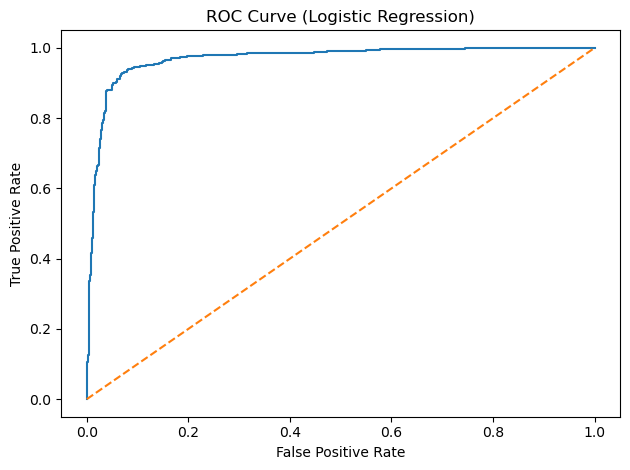

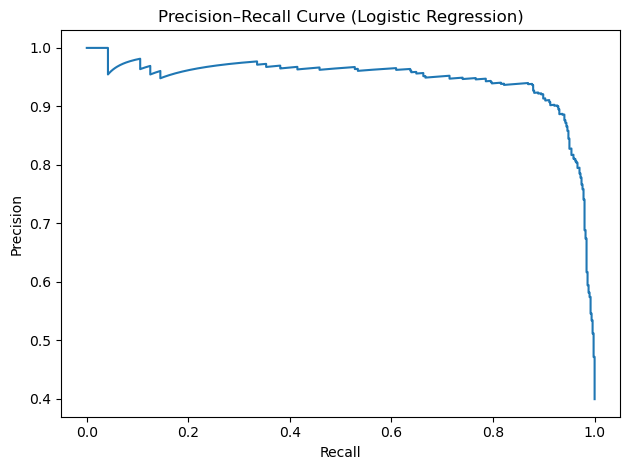


Top positive drivers of spam (log-odds):
char_freq_$                  +1.5605
word_freq_remove             +0.9657
word_freq_free               +0.9169
capital_run_length_longest   +0.8484
char_freq_#                  +0.8323
word_freq_3d                 +0.7842
word_freq_000                +0.7332
capital_run_length_total     +0.6556

Top negative drivers (ham indicators):
word_freq_george             -3.5443
word_freq_hp                 -3.2453
word_freq_edu                -1.3630
word_freq_meeting            -1.2242
word_freq_cs                 -1.0883
word_freq_project            -0.9822
word_freq_lab                -0.9023
word_freq_hpl                -0.8821


In [12]:
# Logistic regression on ALL predictors (class_weight to address imbalance)
logreg = LogisticRegression(
    penalty="l2", C=1.0, solver="liblinear", class_weight="balanced", max_iter=1000
)
logreg.fit(X_train, y_train)

# Coefficients
coef = logreg.coef_[0]
intercept = float(logreg.intercept_[0])

print("LOGISTIC REGRESSION")
print(f"Log-odds equation:")
print(f"logit(P(spam)) = {intercept:.4f} + " +
      " + ".join([f"({c:.4f})*{n}" for c, n in sorted(zip(coef, feature_names), key=lambda t: abs(t[0]), reverse=True)[:8]]) +
      " + ...")

# Predictions & metrics
y_prob = logreg.predict_proba(X_test)[:,1]
y_pred = (y_prob >= 0.5).astype(int)

cm = confusion_matrix(y_test, y_pred)
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
rocauc = roc_auc_score(y_test, y_prob)

print("\nConfusion Matrix [ [TN FP] [FN TP] ]:\n", cm)
print(f"Accuracy: {acc:.4f}  Precision: {prec:.4f}  Recall: {rec:.4f}  F1: {f1:.4f}  ROC-AUC: {rocauc:.4f}")

# ROC curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.figure()
plt.plot(fpr, tpr)
plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Logistic Regression)")
plt.tight_layout(); plt.show()

# PR curve
ps, rs, _ = precision_recall_curve(y_test, y_prob)
plt.figure()
plt.plot(rs, ps)
plt.xlabel("Recall"); plt.ylabel("Precision")
plt.title("Precision–Recall Curve (Logistic Regression)")
plt.tight_layout(); plt.show()

# Top positive drivers
sorted_coef = sorted(zip(feature_names, coef), key=lambda t: t[1], reverse=True)
print("\nTop positive drivers of spam (log-odds):")
for name, c in sorted_coef[:8]:
    print(f"{name:28s} {c:+.4f}")

# Top negative drivers (ham indicators) - FIXED
sorted_neg = sorted(zip(feature_names, coef), key=lambda t: t[1])
print("\nTop negative drivers (ham indicators):")
for name, c in sorted_neg[:8]:
    print(f"{name:28s} {c:+.4f}")